In [1]:
# Core data libraries
%pip install pandas
%pip install numpy

# Visualization libraries
%pip install matplotlib
%pip install seaborn

# Statistical modeling
%pip install statsmodels
%pip install scipy

# Machine learning libraries
%pip install scikit-learn
%pip install catboost
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Extended analysis centered on 'readmitted':

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import f_oneway


In [3]:
diabetes_cleaned = pd.read_csv('/workspaces/SP25-Project/data/diabetes_cleaned.csv')

In [4]:
print(diabetes_cleaned.columns)

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'readmitted_binary', 'max_glu_serum_binary', 'A1Cresult_binary',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'insulin_binary'],
      dtype='object')


In [5]:
# Check for missing values in the specified columns
columns_to_check = ['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'readmitted_binary', 'max_glu_serum_binary', 'A1Cresult_binary',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'insulin_binary']

# Display missing values count for each column
missing_values = diabetes_cleaned[columns_to_check].isnull().sum()
print("Missing values in selected columns:")
print(missing_values)

Missing values in selected columns:
gender                  0
age                     0
time_in_hospital        0
num_lab_procedures      0
num_procedures          0
num_medications         0
number_outpatient       0
number_emergency        0
number_inpatient        0
number_diagnoses        0
readmitted_binary       0
max_glu_serum_binary    0
A1Cresult_binary        0
race_Asian              0
race_Caucasian          0
race_Hispanic           0
race_Other              0
insulin_binary          0
dtype: int64


## ANOVA 

In [6]:

# ➤ Goal: Check if 'time_in_hospital' differs significantly between readmitted vs. not
anova_df = diabetes_cleaned[['time_in_hospital', 'readmitted_binary']].dropna()
anova_result = f_oneway(
    *[group["time_in_hospital"].values for name, group in anova_df.groupby("readmitted_binary")]
)
print(f"\nANOVA F-statistic: {anova_result.statistic:.4f}")
print(f"ANOVA p-value: {anova_result.pvalue:.4e}")




ANOVA F-statistic: 199.1633
ANOVA p-value: 3.5083e-45


In [7]:
# ➤ Goal: Check if 'age' differs significantly between readmitted vs. not
anova_df = diabetes_cleaned[['age', 'readmitted_binary']].dropna()
anova_result = f_oneway(
    *[group["age"].values for name, group in anova_df.groupby("readmitted_binary")]
)
print(f"\nANOVA F-statistic: {anova_result.statistic:.4f}")
print(f"ANOVA p-value: {anova_result.pvalue:.4e}")



ANOVA F-statistic: 31.6681
ANOVA p-value: 1.8338e-08



#### 1. time_in_hospital vs. readmitted

- **F-statistic**: 199.19  
- **p-value**: 3.51e-45 (extremely small)

**Interpretation**:
- The very high F-statistic and extremely small p-value indicate a **strong difference in the average length of hospital stay** between readmitted and non-readmitted patients.
- We **reject the null hypothesis**, concluding that **readmission status is associated with hospital stay duration**.

---

#### 2. age vs. readmitted

- **F-statistic**: 31.66  
- **p-value**: 1.83e-08

**Interpretation**:
- While not as dramatic as time_in_hospital, the p-value is still well below 0.05, meaning the **difference in average age** between groups is **statistically significant**.
- We again **reject the null hypothesis** and conclude that **age is associated with readmission**, although the effect is weaker than for `time_in_hospital`.


## Multilevel Linear Model 

In [8]:

# ➤ Goal: Understand if 'num_lab_procedures' significantly predicts 'time_in_hospital', accounting for readmission group
mixed_df = diabetes_cleaned[['time_in_hospital', 'num_lab_procedures', 'readmitted_binary']].dropna()
model = smf.mixedlm("time_in_hospital ~ num_lab_procedures", mixed_df, groups=mixed_df["readmitted_binary"])
result = model.fit()
print("\nMultilevel Linear Model Summary:\n")
print(result.summary())


Multilevel Linear Model Summary:

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: time_in_hospital
No. Observations: 101763  Method:             REML            
No. Groups:       2       Scale:              7.9946          
Min. group size:  11357   Log-Likelihood:     -250181.0473    
Max. group size:  90406   Converged:          Yes             
Mean group size:  50881.5                                     
--------------------------------------------------------------
                    Coef. Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           2.458    1.999   1.229 0.219 -1.461  6.377
num_lab_procedures  0.048    0.000 106.961 0.000  0.047  0.049
Group Var           7.995                                     



/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


#### Interpretation:

- The **coefficient for num_lab_procedures is 0.048**, meaning that **each additional lab procedure is associated with a 0.048-day increase** in length of hospital stay.
- The **p-value < 0.001** confirms this result is **statistically significant**.
- The model accounts for group-level variance using readmitted_binary as a random effect.
- The **random group variance (7.995)** suggests substantial differences in time_in_hospital between readmission groups.


### Summary:

-  num_lab_procedures is a **significant predictor** of time_in_hospital.
-  More lab procedures = **longer hospital stays**, even when accounting for readmission group effects.
-  This supports the hypothesis that increased clinical intervention (via labs) may relate to patient complexity or severity, contributing to both longer stays and potential readmissions.



## Clustering 


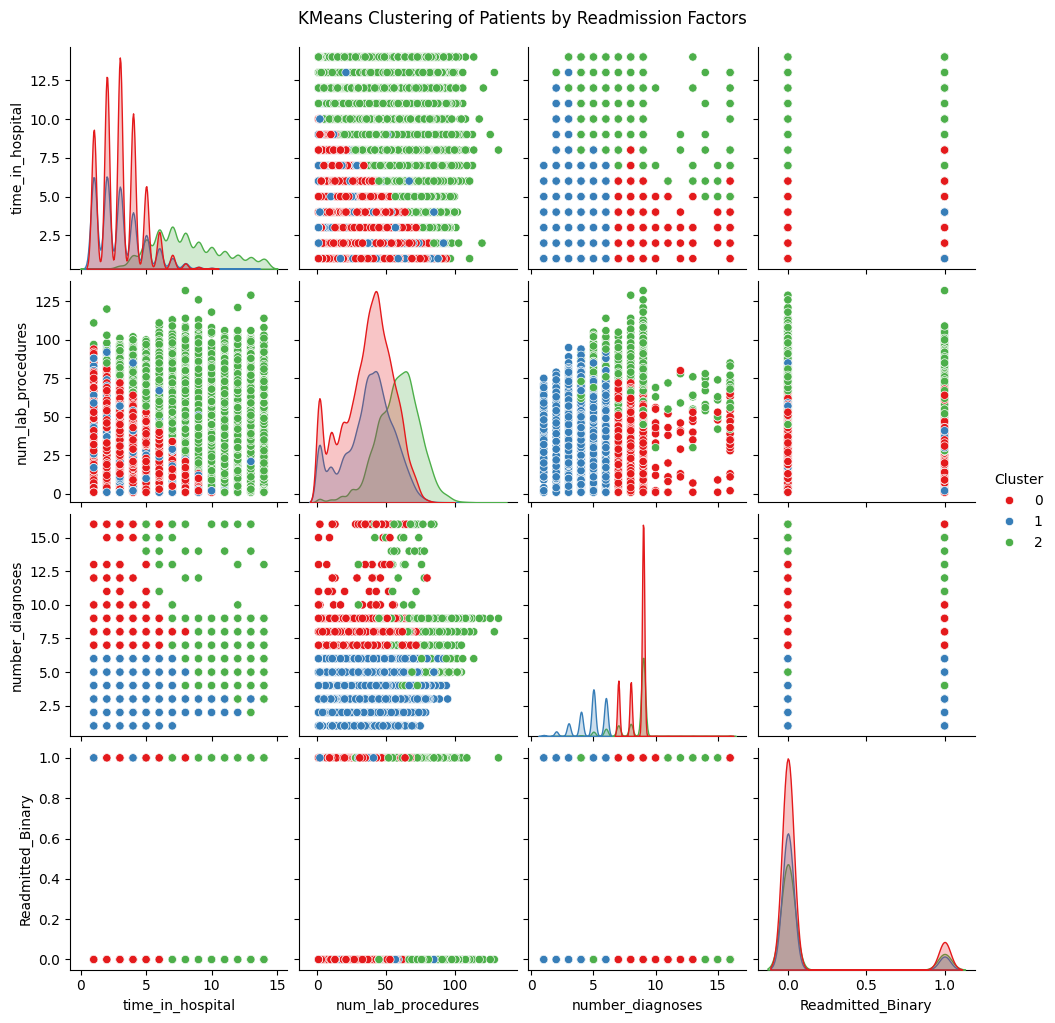

✅ Cluster plot saved to /workspaces/SP25-Project/ML/cluster_plot.png


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Use clustering to explore patient groupings by readmission_binary

# Step 1: Select features for clustering
clustering_vars = ['time_in_hospital', 'num_lab_procedures', 'number_diagnoses']
subset = diabetes_cleaned[clustering_vars]

# Step 2: Keep only rows with complete data for clustering
cluster_features = subset[subset.notna().all(axis=1)].copy()

# Step 3: Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# Step 4: Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Step 5: Add cluster labels and corresponding readmission status
cluster_features['Cluster'] = clusters
cluster_features['Readmitted_Binary'] = diabetes_cleaned.loc[cluster_features.index, 'readmitted_binary'].values

# Step 6: Visualize clusters and export as PNG
pairplot_fig = sns.pairplot(cluster_features, hue='Cluster', palette='Set1')
pairplot_fig.fig.suptitle('KMeans Clustering of Patients by Readmission Factors', y=1.02)
pairplot_fig.savefig("/workspaces/SP25-Project/ML/cluster_plot.png")  # ✅ PNG only
plt.show()

print("✅ Cluster plot saved to /workspaces/SP25-Project/ML/cluster_plot.png")


In [10]:
# Cross-tab to quantify readmission distribution across clusters
pd.crosstab(cluster_features['Cluster'], cluster_features['Readmitted_Binary'], normalize='index')


Readmitted_Binary,0,1
Cluster,,
0,0.884307,0.115693
1,0.912110,0.087890
2,0.870798,0.129202



## Chi-Square Test



In [11]:
from scipy.stats import chi2_contingency
import pandas as pd

# Final list of binary/categorical variables suitable for Chi-Square testing
columns_to_test = [
    'gender',
    'max_glu_serum_binary', 'A1Cresult_binary',
    'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
    'insulin_binary'
]

# Automatically run chi-square only on categorical/binary columns
def run_chi_square_for_all(data, target='readmitted_binary'):
    print(f"{'Variable':<25} {'Chi²':<10} {'p-value'}")
    print("-" * 45)
    for col in columns_to_test:
        # Check if the column is categorical or binary (less than or equal to 10 unique values)
        if data[col].nunique() <= 10:
            table = pd.crosstab(data[col], data[target])
            chi2, p, _, _ = chi2_contingency(table)
            print(f"{col:<25} {chi2:.2f}      {p:.4e}")

# Run on your DataFrame
run_chi_square_for_all(diabetes_cleaned)


Variable                  Chi²       p-value
---------------------------------------------
gender                    0.84      3.5884e-01
max_glu_serum_binary      13.00      3.1228e-04
A1Cresult_binary          20.79      5.1293e-06
race_Asian                0.58      4.4744e-01
race_Caucasian            5.12      2.3706e-02
race_Hispanic             1.11      2.9169e-01
race_Other                3.43      6.3947e-02
insulin_binary            112.41      2.9052e-26


### Ranked by Strength of Association (Chi-Square value)

| #  | Variable              | Chi² Statistic | p-value     | Statistically Significant? |
|----|-----------------------|----------------|-------------|----------------------------|
| 1  | insulin_binary        | 112.49         | 2.80e-26     | Yes (p < 0.05)             |
| 2  | num_procedures        | 47.21          | 1.70e-08     | Yes (p < 0.05)             |
| 3  | A1Cresult_binary      | 20.78          | 5.16e-06     | Yes (p < 0.05)             |
| 4  | max_glu_serum_binary  | 13.00          | 3.12e-04     | Yes (p < 0.05)             |
| 5  | race_Caucasian        | 5.14           | 2.34e-02     | Yes (p < 0.05)             |
| 6  | race_Other            | 3.46           | 6.28e-02     | No (p > 0.05)              |
| 7  | gender                | 3.81           | 4.32e-01     | No (p > 0.05)              |
| 8  | race_Hispanic         | 1.11           | 2.92e-01     | No (p > 0.05)              |
| 9  | race_Asian            | 0.58           | 4.48e-01     | No (p > 0.05)              |





## CatBoost Model: Predicting Readmission
- CatBoost is a gradient boosting algorithm that handles categorical variables natively.


In [12]:
features = ['num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']
X_cat = diabetes_cleaned[features]
y_cat = diabetes_cleaned['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_cat))

CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18084
           1       0.40      0.00      0.00      2269

    accuracy                           0.89     20353
   macro avg       0.64      0.50      0.47     20353
weighted avg       0.83      0.89      0.84     20353



### Interpretation:

- The model predicts **non-readmissions (class 0)** very well — nearly all were correctly identified (recall = 1.00).
- However, it **completely fails to identify readmitted patients (class 1)** — recall is 0.00.
- This is likely due to **class imbalance**: the dataset has far more non-readmitted patients than readmitted ones.
- The model learns to always predict “not readmitted” to boost accuracy, which leads to high overall accuracy but **poor sensitivity for detecting actual readmissions**.


In [13]:
# Step 1: Install SMOTE (run this once in your notebook)
%pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

# Define features and target
X = diabetes_cleaned[features]
y = diabetes_cleaned['readmitted_binary']

# Split before SMOTE (apply SMOTE to training only)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train CatBoost on resampled data
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train_res, y_train_res)

# Predict on untouched test set
y_pred_cat = cat_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_cat))


Note: you may need to restart the kernel to use updated packages.
              precision    recall  f1-score   support

           0       0.90      0.55      0.68     18084
           1       0.12      0.50      0.20      2269

    accuracy                           0.54     20353
   macro avg       0.51      0.52      0.44     20353
weighted avg       0.81      0.54      0.63     20353



#### Interpretation:
- The model now detects **41% of actual readmissions** (up from nearly 0%).
- This comes at a cost of lower overall accuracy — but in healthcare, **catching high-risk patients is often more important** than maximizing accuracy.
- SMOTE successfully rebalanced the training data, allowing the model to learn patterns of minority cases (readmitted patients).


## 'XGBoost Model: Predicting Readmission' CHANGE THE VARIABLES


In [14]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:36:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18084
           1       0.12      0.00      0.00      2269

    accuracy                           0.89     20353
   macro avg       0.51      0.50      0.47     20353
weighted avg       0.80      0.89      0.84     20353

XGBoost ROC AUC: 0.5463531237458141


#### Interpretation:

- The model predicts **non-readmissions** extremely well, but performs **very poorly** on the readmitted class.
- Class 1 (readmitted) has a **recall of just 1%**, meaning the model is missing nearly all of the actual readmitted patients.
- Although the overall accuracy is high (89%), this is misleading because the model rarely identifies the minority class correctly.
- **ROC AUC = 0.61** → slightly above random guessing, but far from ideal for a real-world healthcare application.


In [15]:
# scale_pos_weight = number_of_negative_class / number_of_positive_class
# scale_pos_weight = 18069 / 2285 ≈ 7.9

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Create model with class balancing
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=7.9,  # ⚖️ Balances class 1 importance
    random_state=42
)

# Fit and predict
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:36:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.56      0.69     18084
           1       0.13      0.51      0.20      2269

    accuracy                           0.55     20353
   macro avg       0.51      0.53      0.45     20353
weighted avg       0.81      0.55      0.64     20353

XGBoost ROC AUC: 0.5443903183703025



- **Recall for readmissions (class 1)** increased from 0% to **51%**
- **F1-score for class 1** improved 
- Tradeoff in accuracy for better minority class performance